In [2]:
import sys
import os

path = os.path.join('..', '/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox')
if path not in sys.path:
    sys.path.append(os.path.abspath(path))

import datetime
import random

import numpy as np
import pandas as pd
import copy

import torch
from torch_geometric.data import Data

import wandb

import MDAnalysis
from MDAnalysis.analysis.distances import distance_array

import networkx as nx

from tqdm import tqdm

import sbmlcore
import sbmlsim
import gumpy

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

from src import run_model, protein_graph, gcn_model, evaluation

%aimport src

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create Train and Test Sequences from Carter paper

In [4]:
reference = gumpy.Genome('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/NC_000962.3.gbk')
pnca = reference.build_gene('pncA')

In [3]:
# recreate train/test dataset from pncA paper
pnca_paper_dataset = pd.read_csv('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/ds-traintest-phen.csv')
pnca_paper_dataset.CONSISTENT_PHENOTYPE.value_counts()

CONSISTENT_PHENOTYPE
R    349
S    315
Name: count, dtype: int64

In [6]:
def split_mutation(row):
    return pd.Series([row.MUTATION[0], int(row.MUTATION[1:-1]), row.MUTATION[-1]])

pnca_paper_dataset[['REF','AMINO_ACID','ALT']] = pnca_paper_dataset.apply(split_mutation,axis=1)

In [18]:
from sklearn.model_selection import train_test_split

mutations_dict = {}

mutations_dict['train'], mutations_dict['test'] = train_test_split(pnca_paper_dataset, test_size=0.3, random_state=42)

### Augment Train and Test datasets with SBMLSsim

In [30]:
def get_muts_list(df):
    r_list = list(df[df.CONSISTENT_PHENOTYPE=='R'].MUTATION.drop_duplicates())
    s_list = list(df[df.CONSISTENT_PHENOTYPE=='S'].MUTATION.drop_duplicates())
    r_list = ['pncA@' + x for x in r_list]
    s_list = ['pncA@' + x for x in s_list]
    return r_list, s_list

In [33]:
train_res_list, train_sus_list = get_muts_list(mutations_dict['train'])
test_res_list, test_sus_list = get_muts_list(mutations_dict['test'])

In [37]:
print('Num resistant mutations in train:',len(train_res_list), 'Num susceptible mutations in train', len(train_sus_list))
print('Num resistant mutations in test:', len(test_res_list), 'Num susceptible mutations in test:', len(test_sus_list))

Num resistant mutations in train: 246 Num susceptible mutations in train 218
Num resistant mutations in test: 103 Num susceptible mutations in test: 97


In [38]:
train_batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations = train_res_list,
                        susceptible_mutations = train_sus_list,
                        genbank_file='/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/NC_000962.3.gbk'
                    )

test_batch = sbmlsim.Batch(  gene='pncA', 
                        drug='PZA', 
                        resistant_mutations = test_res_list,
                        susceptible_mutations = test_sus_list,
                        genbank_file='/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/data/NC_000962.3.gbk'
                    )

In [54]:
seed = 42
np.random.seed(seed)
random.seed(seed)

n_samples = 10000

train_prop = len(train_res_list)/(len(train_res_list)+len(train_sus_list))
test_prop = len(test_res_list)/(len(test_res_list)+len(test_sus_list))

train_sequences, train_mutations = train_batch.generate(n_samples=int(n_samples*0.7),
                                                  proportion_resistant=train_prop,
                                                  n_res = 1,
                                                  n_sus = 1)

test_sequences, test_mutations = test_batch.generate(n_samples=int(n_samples*0.3),
                                                  proportion_resistant=test_prop,
                                                  n_res = 1,
                                                  n_sus = 1)

train_sequences.rename(columns = {'pncA':'allele'}, inplace=True)
test_sequences.rename(columns = {'pncA':'allele'}, inplace=True)

In [55]:
sequences_dict = {'train': train_sequences, 'test': test_sequences}

### Run

In [56]:
cutoff_distance = 6.3  
# gcn params
num_node_features = 12
batch_size = 64
hidden_channels = 64
learning_rate = 0.001
wd = 5e-5
epochs = 400

model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=sequences_dict,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    # edge_weight_func = '1-(dist/cutoff)',
    edge_weight_func= 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    normalise_ews=True,
    wandb_params={
        'use_wandb' : True,
        'wandb_project' : 'PncA Split Set',
        'wandb_name' : f'Simple GCN n_samples = {n_samples}',
        'n_samples' : n_samples
    }
)

100%|██████████| 3000/3000 [00:23<00:00, 130.15it/s]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dylan-home. Use `wandb login --relogin` to force relogin


Epoch: 010, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6915, Test Loss: 0.6927
Epoch: 020, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6908, Test Loss: 0.6916
Epoch: 030, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6914, Test Loss: 0.6925
Epoch: 040, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6926
Epoch: 050, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6914, Test Loss: 0.6924
Epoch: 060, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6924
Epoch: 070, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6915, Test Loss: 0.6927
Epoch: 080, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6924
Epoch: 090, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6914, Test Loss: 0.6924
Epoch: 100, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6915, Test Loss: 0.6925
Epoch: 110, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6925
Epoch: 120, Train Acc: 0.5283, Test Acc: 0.

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Test Accuracy,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▅▆▅▁▅▆▅█▇█▆▇█▇▇▇▇▇▇██▇██
Test Loss,████████████████▆▅▅▅▅▃▆▂▃▁▄▁▁▁▂▁▂▂▂▁▁▃▁▂
Train Accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆▆▆▁▅▆▅▇▇▇▆▇▇▇▇▇▇▇▇██▇██
Train Loss,███████████████▇▅▅▄▅▄▃▅▃▃▂▃▂▂▂▂▁▂▂▂▁▁▂▁▁
Test Accuracy,0.75767
Test Loss,0.58595
Train Accuracy,0.75929
Train Loss,0.51526


In [67]:
model.train_sequences = train_sequences
model.train_mutations = train_mutations
model.test_sequences = test_sequences
model.test_mutations = test_mutations

torch.save(model, f'saved_models/n{n_samples}_aug_split_seed{seed}_{datetime.datetime.now().strftime("%Y_%m_%d_%H%M%S")}')

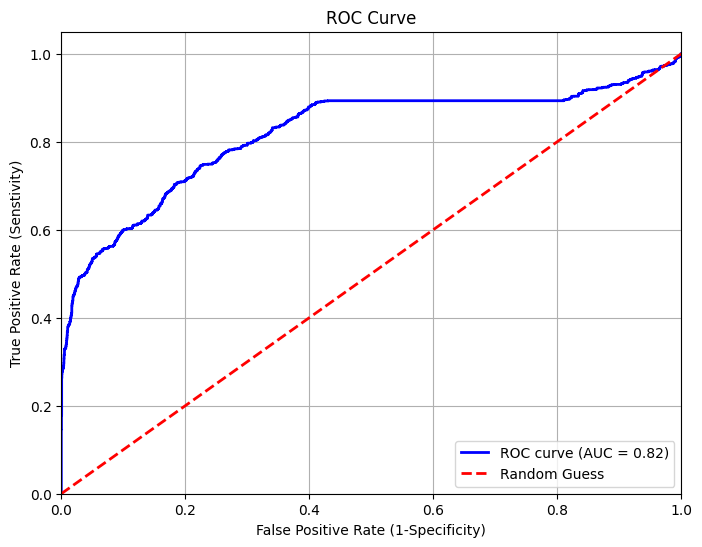

Number predicted resistant = 3489. Number labeled R = 3698
Number predicted susceptible = 3511. Number labeled S = 3302
Sensitivity: 0.74
Specificity: 0.78


(0.7439156300703083, 0.7764990914597214)

In [111]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.train_loader)

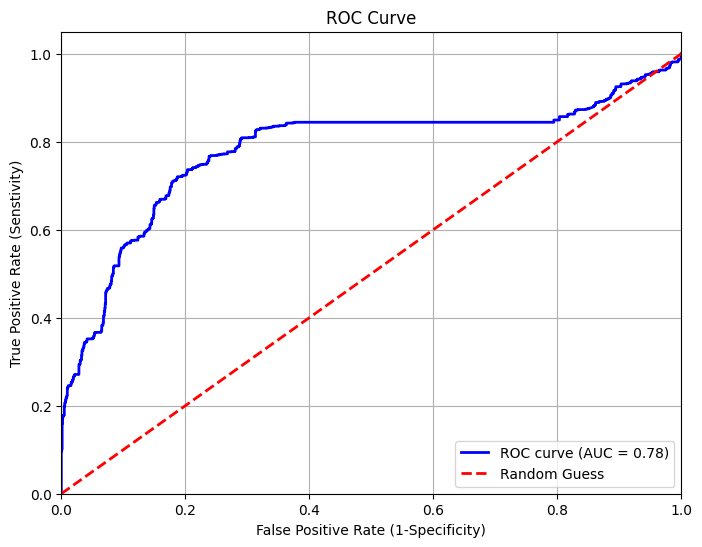

Number predicted resistant = 1339. Number labeled R = 1560
Number predicted susceptible = 1661. Number labeled S = 1440
Sensitivity: 0.70
Specificity: 0.82


(0.6961538461538461, 0.8243055555555555)

In [110]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, model.test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, model.test_loader)

### Evaluate against original paper mutations

In [93]:
def convert_mutations_to_samples(mutations_df):
    out_df = pd.DataFrame(columns=['phenotype_label','number_resistant_mutations', 'number_susceptible_mutations', 'allele'])

    for idx, row in mutations_df.iterrows():
    
        sample = copy.deepcopy(pnca)
        # reassign amino acid to mutated amino acid
        sample.amino_acid_sequence[sample.amino_acid_number==row.AMINO_ACID] = row.ALT
        
        sequence = ''.join(i for i in sample.amino_acid_sequence)
        
        if row.CONSISTENT_PHENOTYPE == 'R':
            number_resistant_mutations = 1
            number_susceptible_mutations = 0
            phenotype_label = 'R'
        else:
            number_resistant_mutations = 0
            number_susceptible_mutations = 1
            phenotype_label = 'S'
            
        out_df.loc[len(out_df)] = [phenotype_label, number_resistant_mutations, number_susceptible_mutations, sequence]
    
    return out_df

In [94]:
from torch_geometric.data import DataLoader

real_train_sequences = convert_mutations_to_samples(mutations_dict['train'])

real_pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                     lig_resname='PZA', 
                     self_loops=False,
                     cutoff_distance=6.3)

real_pnca.gen_dataset(
        'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS', 
        sequences=real_train_sequences,
        edge_weights= 'none',
        normalise=False
        )

real_train_loader = DataLoader(real_pnca.dataset, batch_size=64, shuffle=True)

100%|██████████| 464/464 [00:03<00:00, 121.68it/s]


In [108]:
model = torch.load('/Users/dylandissanayake/Desktop/DPhil/Comp Disc/Repositories/gcn-sandbox/dd_pnca/saved_models/n10000_aug_split_seed42_2024_11_12_134653')

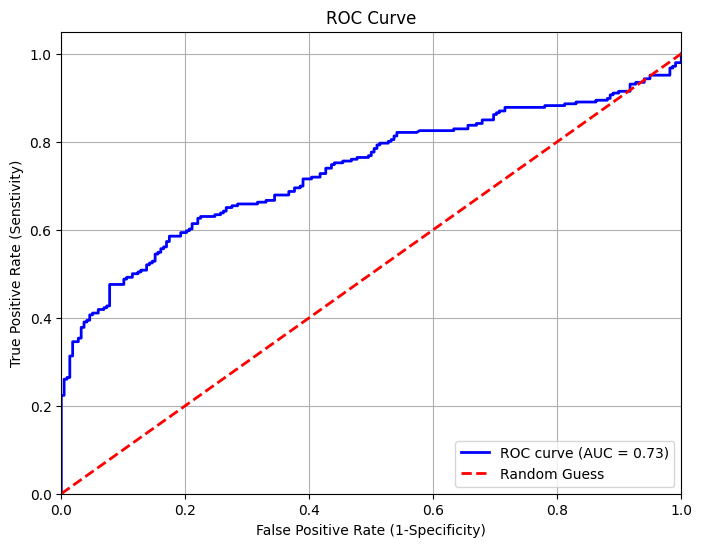

Number predicted resistant = 202. Number labeled R = 246
Number predicted susceptible = 262. Number labeled S = 218
Sensitivity: 0.63
Specificity: 0.78


(0.6260162601626016, 0.7798165137614679)

In [97]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, real_train_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, real_train_loader)

In [98]:
real_test_sequences = convert_mutations_to_samples(mutations_dict['test'])

real_pnca = protein_graph.pncaGraph(pdb='../pdb/3PL1-PZA.pdb',
                     lig_resname='PZA', 
                     self_loops=False,
                     cutoff_distance=6.3)

real_pnca.gen_dataset(
        'MRALIIVDVQNDFCEGGSLAVTGGAALARAISDYLAEAADYHHVVATKDFHIDPGDHFSGTPDYSSSWPPHCVSGTPGADFHPSLDTSAIEAVFYKGAYTGAYSGFEGVDENGTPLLNWLRQRGVDEVDVVGIATDHCVRQTAEDAVRNGLATRVLVDLTAGVSADTTVAALEEMRTASVELVCS', 
        sequences=real_test_sequences,
        edge_weights= 'none',
        normalise=False
        )

real_test_loader = DataLoader(real_pnca.dataset, batch_size=64, shuffle=True)

100%|██████████| 200/200 [00:01<00:00, 118.28it/s]


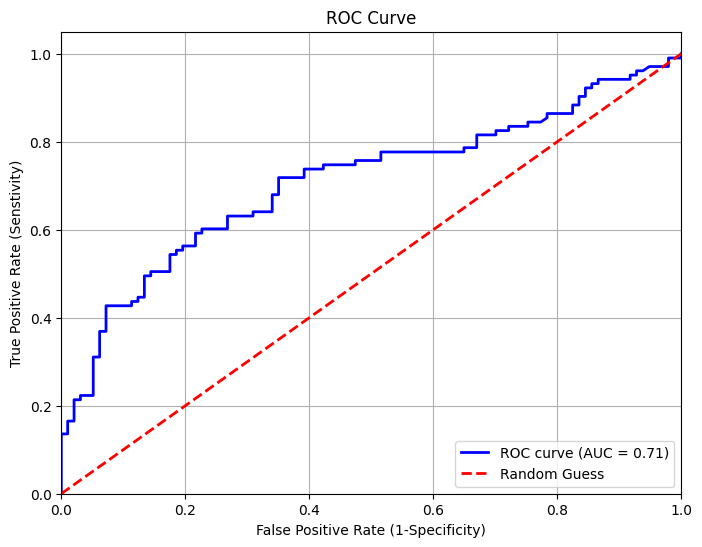

Number predicted resistant = 71. Number labeled R = 103
Number predicted susceptible = 129. Number labeled S = 97
Sensitivity: 0.52
Specificity: 0.82


(0.5242718446601942, 0.8247422680412371)

In [99]:
fpr, tpr, roc_auc = evaluation.calculate_roc(model, real_test_loader)
evaluation.plot_roc_curve(fpr, tpr, roc_auc)
evaluation.calculate_sens_spec(model, real_test_loader)

### Rerun with 1 as output dim

In [106]:
cutoff_distance = 6.3  
# gcn params
# num_node_features = 12
num_node_features = 4
batch_size = 64
hidden_channels = 64
# learning_rate = 5e-5
# wd = 1e-5
learning_rate = 1e-3
wd = 5e-5
epochs = 400

model, train_acc, test_acc, train_loss, test_loss= run_model.pnca_simpleGCN(
    sequences=sequences_dict,
    self_loops = False,
    cutoff_distance = cutoff_distance,
    # edge_weight_func = '1-(dist/cutoff)',
    edge_weight_func= 'none',
    batch_size = batch_size,
    num_node_features = num_node_features,
    hidden_channels = hidden_channels,
    learning_rate = learning_rate,
    wd = wd,
    epochs = epochs,
    normalise_ews=True,
    wandb_params={
        'use_wandb' : True,
        'wandb_project' : 'PncA Split Set',
        'wandb_name' : f'Only distance/stride node features',
        'n_samples' : n_samples
    }
)

100%|██████████| 3000/3000 [00:04<00:00, 642.33it/s]


Epoch: 010, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6925
Epoch: 020, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6915, Test Loss: 0.6925
Epoch: 030, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6915, Test Loss: 0.6924
Epoch: 040, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6915, Test Loss: 0.6925
Epoch: 050, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6925
Epoch: 060, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6923, Test Loss: 0.6938
Epoch: 070, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6924
Epoch: 080, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6926
Epoch: 090, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6916, Test Loss: 0.6924
Epoch: 100, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6915, Test Loss: 0.6925
Epoch: 110, Train Acc: 0.5283, Test Acc: 0.5200, Train Loss: 0.6917, Test Loss: 0.6926
Epoch: 120, Train Acc: 0.5283, Test Acc: 0.

KeyboardInterrupt: 